<a href="https://colab.research.google.com/github/TRshyam/colab/blob/main/digitre_cog_nn_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as fun
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split,DataLoader,TensorDataset
from torchvision.utils import make_grid

%matplotlib inline
matplotlib.rcParams['figure.facecolor']='#ffffff'

In [ ]:
db=MNIST(root='data/',download=True)

In [ ]:
train_db=MNIST(root='data/',train=True,transform=transforms.ToTensor())
len(train_db)


60000

In [ ]:
test_db=MNIST(root='data/',train=False,transform=transforms.ToTensor())
len(test_db)

10000

torch.Size([1, 28, 28])
torch.Size([28, 28, 1])


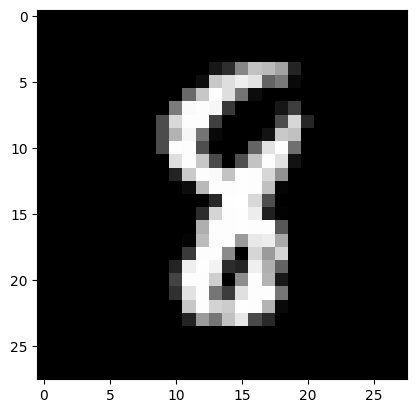

In [ ]:
img,lab=test_db[1286]
print(img.shape)
print(img.permute(1,2,0).shape)
img_sho=img.permute(1,2,0)
plt.imshow(img_sho,cmap="gray")
# print(lab)

In [ ]:
train_db,val_db=random_split(train_db,[50000,10000])
len(train_db),len(val_db)

(50000, 10000)

In [ ]:
train_dl=DataLoader(train_db,batch_size=128,shuffle=True)
val_dl=DataLoader(val_db,batch_size=128)

In [ ]:
train_dl

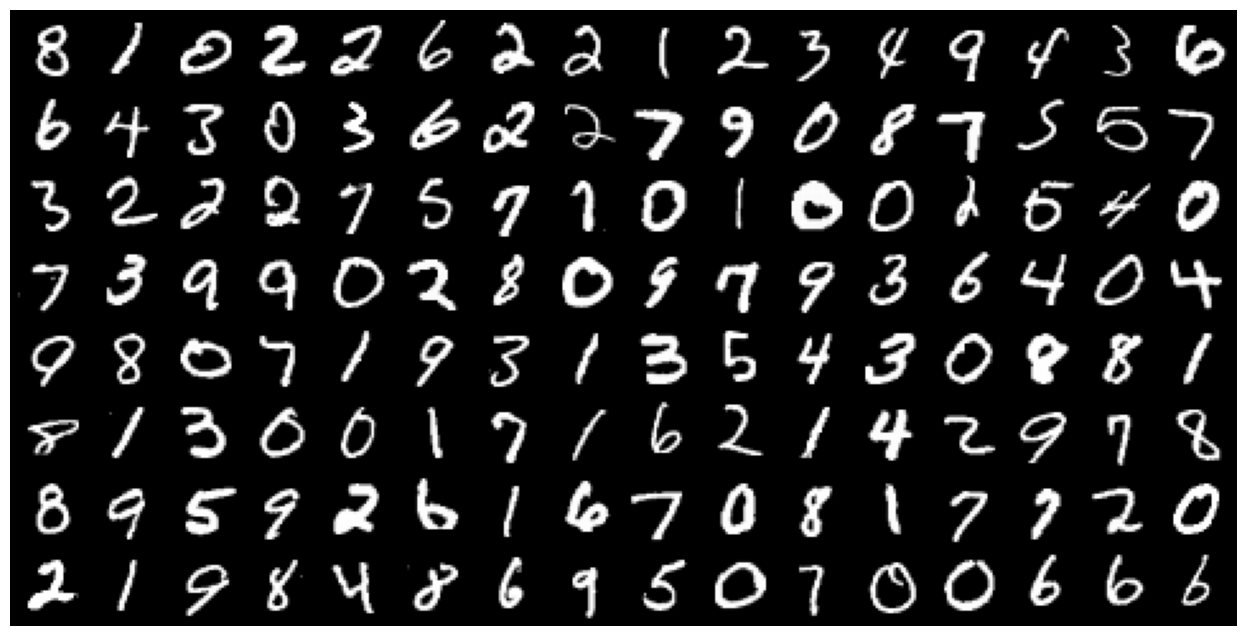

In [ ]:
for img,_ in train_dl:
  # print(img.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  # print(img.permute(1,2,0)).shape
  plt.imshow(make_grid(img,nrow=16).permute(1,2,0))
  break



In [ ]:
for img,lab in train_dl:
  print(img.shape)
  inp=img.reshape(-1,784)
  print(inp.shape)
  break

torch.Size([128, 1, 28, 28])
torch.Size([128, 784])


In [ ]:
def evl(model,val_dl):
  outputs=[model.val_step(batch)for batch in val_dl]
  # print(outputs)
  return model.val_epo_end(outputs)

In [ ]:
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    acc = correct / total
    return torch.tensor(acc)

In [ ]:
class mnistModel(nn.Module):

  def __init__(self,inp_size,hidden_size,out_size):
    super().__init__()
    self.linear1=nn.Linear(inp_size,hidden_size)
    self.linear2=nn.Linear(hidden_size,out_size)

  def forward(self,xb):
    # xb=xb.reshape(-1,784)
    xb=xb.view(xb.size(0),-1)
    out=self.linear1(xb)

    out=fun.relu(out)

    out=self.linear2(out)
    return out


  def training_step(self,batch):
    img,lab=batch
    out=self(img)
    loss=fun.cross_entropy(out,lab)
    return loss

  def val_step(self,batch):
    img,lab=batch
    out=self(img)
    loss=fun.cross_entropy(out,lab)
    acc=accuracy(out,lab)
    return {'val_loss':loss,'val_acc':acc}


  def val_epo_end(self,outputs):
    batch_loss=[x['val_loss']for x in outputs]
    epoch_loss=torch.stack(batch_loss).mean()
    batch_acc=[x['val_acc']for x in outputs]
    epoch_acc=torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epo_end(self,epo,res):
    print('epoch[{}],val_loss:{:.4f},val_acc:{:.4f}'.format(epo,res['val_loss'],res['val_acc']))


In [ ]:
input_size=inp.shape[-1]
hidden_size=32
output=10

In [ ]:
model=mnistModel(input_size,hidden_size,output)

In [ ]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
for img,lab in train_dl:
  out=model(img)
  break
loss=fun.cross_entropy(out,lab)
loss.item()

2.315206527709961

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# prompt: set device gpu or cpu

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# prompt: make a function to move the data and the model to the device

# def move_to_device(data,device):
#   if data is not None:
#     data=data.to(device,non_blocking=True)
#     print(data)
#   return data


def move_to_device(data, device):
    if isinstance(data, list):
        # If the input is a list, assume it's a list of tensors
        return [move_to_device(item, device) for item in data]
    elif isinstance(data, torch.Tensor):
        # If the input is a tensor, move it to the specified device
        return data.to(device, non_blocking=True)
    else:
        # If it's neither a list nor a tensor, return as is
        return data



In [ ]:
# for d in train_dl:
#   print(img.shape)
#   img=move_to_device(img,device)
#   print(img.device)


In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.dev = device

    def __iter__(self):
        for batch in self.dl:
            yield move_to_device(batch, self.dev)

    def __len__(self):
        return len(self.dl)



In [ ]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

In [ ]:
# for xb, yb in val_d1:
#     print(xb.device)
#     break

In [ ]:
# for xb,yb in train_dl:
#   print(xb.device)
#   # print(yb)
#   break

In [ ]:
def fit(epochs,model,train_dl,val_dl,lr):
  opt=torch.optim.SGD(model.parameters(),lr)
  his=[]

  for epoch in range(epochs):
    for batch in train_dl:
      loss=model.training_step(batch)
      # print(loss)
      loss.backward()
      opt.step()
      opt.zero_grad()

    result=evl(model,val_dl)
    print(epoch)
    print(result)

    model.epo_end(epoch,result)
    his.append(result)
  return his


In [ ]:
# prompt: model on gpu

model=mnistModel(input_size,hidden_size,output).to(device)
model

mnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
h1=fit(5,model,train_dl,val_dl,0.2)

0
{'val_loss': 0.3406495153903961, 'val_acc': 0.9028876423835754}
epoch[0],val_loss:0.3406,val_acc:0.9029
1
{'val_loss': 0.25784480571746826, 'val_acc': 0.925929605960846}
epoch[1],val_loss:0.2578,val_acc:0.9259
2
{'val_loss': 0.2230088710784912, 'val_acc': 0.9333465099334717}
epoch[2],val_loss:0.2230,val_acc:0.9333
3
{'val_loss': 0.19113439321517944, 'val_acc': 0.944719135761261}
epoch[3],val_loss:0.1911,val_acc:0.9447
4
{'val_loss': 0.17689071595668793, 'val_acc': 0.9491692781448364}
epoch[4],val_loss:0.1769,val_acc:0.9492


In [ ]:
h2=fit(5,model,train_dl,val_dl,0.1)


0
{'val_loss': 0.16354064643383026, 'val_acc': 0.9526305198669434}
epoch[0],val_loss:0.1635,val_acc:0.9526
1
{'val_loss': 0.1631745547056198, 'val_acc': 0.9529272317886353}
epoch[1],val_loss:0.1632,val_acc:0.9529
2
{'val_loss': 0.1525656133890152, 'val_acc': 0.9566851258277893}
epoch[2],val_loss:0.1526,val_acc:0.9567
3
{'val_loss': 0.15443070232868195, 'val_acc': 0.9561906456947327}
epoch[3],val_loss:0.1544,val_acc:0.9562
4
{'val_loss': 0.14810699224472046, 'val_acc': 0.9586629867553711}
epoch[4],val_loss:0.1481,val_acc:0.9587


In [ ]:
h3=fit(10,model,train_dl,val_dl,0.01)


0
{'val_loss': 0.12002382427453995, 'val_acc': 0.9668710231781006}
epoch[0],val_loss:0.1200,val_acc:0.9669
1
{'val_loss': 0.12005562335252762, 'val_acc': 0.9668710231781006}
epoch[1],val_loss:0.1201,val_acc:0.9669
2
{'val_loss': 0.12038999050855637, 'val_acc': 0.9667721390724182}
epoch[2],val_loss:0.1204,val_acc:0.9668
3
{'val_loss': 0.12018364667892456, 'val_acc': 0.9663766026496887}
epoch[3],val_loss:0.1202,val_acc:0.9664
4
{'val_loss': 0.12025091052055359, 'val_acc': 0.9662777185440063}
epoch[4],val_loss:0.1203,val_acc:0.9663
5
{'val_loss': 0.12010487914085388, 'val_acc': 0.9659810066223145}
epoch[5],val_loss:0.1201,val_acc:0.9660
6
{'val_loss': 0.11994419991970062, 'val_acc': 0.9660798907279968}
epoch[6],val_loss:0.1199,val_acc:0.9661
7
{'val_loss': 0.11993411183357239, 'val_acc': 0.9663766026496887}
epoch[7],val_loss:0.1199,val_acc:0.9664
8
{'val_loss': 0.12010789662599564, 'val_acc': 0.9663766026496887}
epoch[8],val_loss:0.1201,val_acc:0.9664
9
{'val_loss': 0.12034958600997925, '

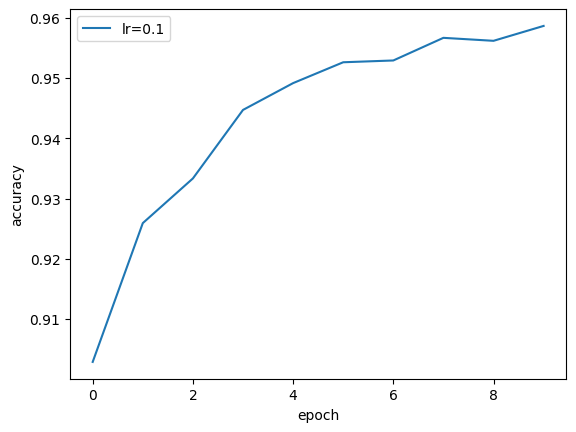

In [ ]:
# prompt: plot epocn and acc of both h1 and h2
h=h1+h2
# plt.plot([x['val_acc'] for x in h1],label='lr=0.2')
plt.plot([x['val_acc'] for x in h],label='lr=0.1')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [ ]:
test_db

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()

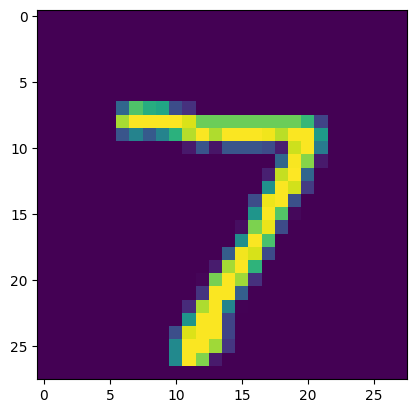

In [ ]:
img,lab=test_db[0]
plt.imshow(img[0])

In [ ]:
def pre(img,model):
  x=move_to_device(img.unsqueeze(0),device)
  y=model(x)
  _,pred=torch.max(y,dim=1)
  return pred[0].item()


9


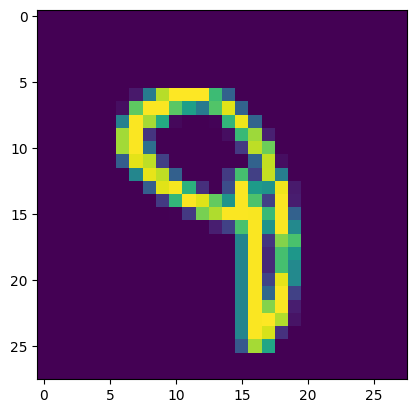

In [ ]:
img,lab=test_db[193]
plt.imshow(img[0])
print(pre(img,model))

In [ ]:
test_dl=DataLoader(test_db,batch_size=256)
test_dl=DeviceDataLoader(test_dl,device)
res=evl(model,test_dl)
res


{'val_loss': 0.10153817385435104, 'val_acc': 0.969531238079071}